# Introduction

In [13]:
#!pip install -r requirements.txt

In [1]:
import pandas as pd

df = pd.read_csv("pdf_texts_cleaned.csv")
print(df.head())

         filename                                               text label
0  hp_doc_281.pdf  Product Carbon Footprint Report\n23-Aug-2023\n...    pc
1  hp_doc_282.pdf   \n Product carbon footprint  \nHP 200 Pro G4 ...    pc
2  hp_doc_283.pdf   \n Product carbon footprint  \nHP 20 5 G4 22 ...    pc
3  hp_doc_284.pdf   \n Product carbon footprint  \nHP 205 G4 24 A...    pc
4  hp_doc_285.pdf   \n Product carbon footprint  \nHP 20 5 Pro G4...    pc


Même si on n’a qu’une colonne texte comme information, la vectorisation (comme TF-IDF) transforme le texte en une matrice numérique où chaque colonne correspond à un mot (ou un n-gramme), et chaque ligne correspond à un document.

Par exemple, si des mots comme "screen size", "display", "monitor" sont fréquents dans les textes de moniteurs tandis que "CPU", "RAM", "all-in-one", "PC" sont fréquents dans les textes de PCs, alors le modèle va apprendre à s’en servir pour prédire la bonne étiquette.

## 4. Vectorisation (TF-IDF)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialiser le vectoriseur TF-IDF
tfidf = TfidfVectorizer(
    max_features=1000,         # Tu peux ajuster ce nombre
    stop_words='english',      # Pour retirer les mots vides courants
    ngram_range=(1, 2)         # Unigrammes + bigrammes
)

# Appliquer sur la colonne texte
X_tfidf = tfidf.fit_transform(df['text'])

# Pour voir le résultat
print(f"Shape du vecteur TF-IDF : {X_tfidf.shape}")

Shape du vecteur TF-IDF : (530, 1000)


530 documents (lignes) et 1 000 caractéristiques (colonnes de l'espace vectoriel). Chaque ligne représente un texte transformé en vecteur numérique, prêt pour l’entraînement d’un modèle.

## 5. Modèles de classification

### 5.1 Régression logistique

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Séparer les données en features (X) et labels (y)
X = X_tfidf
y = df['label']

# Diviser en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser et entraîner le modèle
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Prédictions sur le jeu de test
y_pred = model.predict(X_test)

# Afficher le rapport de classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    monitors       0.96      1.00      0.98        50
          pc       1.00      0.96      0.98        56

    accuracy                           0.98       106
   macro avg       0.98      0.98      0.98       106
weighted avg       0.98      0.98      0.98       106



Résultats très bons avec un modèle de base qu'est la régression logistique. On voit que le modèle ne se trompe presque pas (98% de précision).

### 5.2  Top mots par classe 

In [11]:
import numpy as np

# Récupérer les noms des features (mots ou n-grammes)
feature_names = tfidf.get_feature_names_out()

# Récupérer les coefficients du modèle
coefs = model.coef_[0]  # Pour une régression logistique binaire, c'est un vecteur

# Top mots pour la classe 'pc' (valeurs positives)
top_pc = np.argsort(coefs)[-5:]  # 5 plus grands
print("Top mots pour classer en 'pc':")
for idx in reversed(top_pc):
    print(f"{feature_names[idx]}: {coefs[idx]:.4f}")

# Top mots pour la classe 'monitors' (valeurs négatives)
top_monitors = np.argsort(coefs)[:5]  # 5 plus petits
print("\nTop mots pour classer en 'monitors':")
for idx in top_monitors:
    print(f"{feature_names[idx]}: {coefs[idx]:.4f}")

Top mots pour classer en 'pc':
desktop: 2.6769
drive: 1.9693
computer specifications: 1.6418
computer: 1.6204
pc: 1.5988

Top mots pour classer en 'monitors':
display: -3.0689
monitor: -2.0430
display specifications: -1.6737
average display: -1.6737
inches product: -1.2052


Sans surprise, le mot le plus discriminant pour les pc est "desktop" et pour les écrans c'est "display".
Affichage graphique :

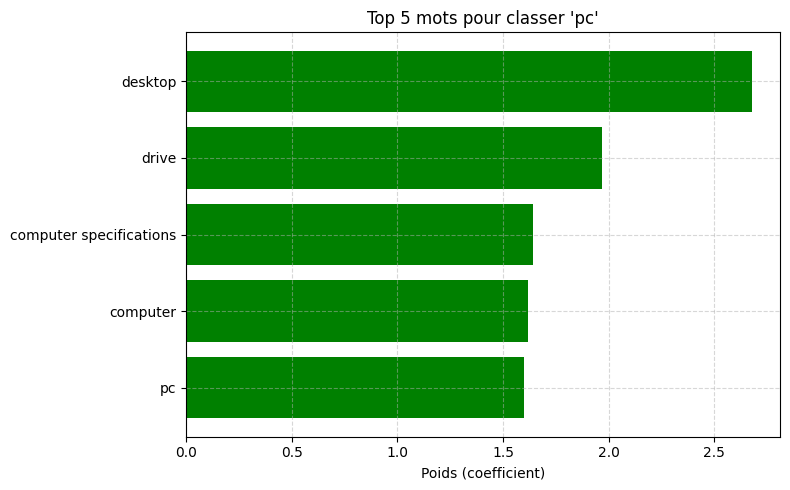

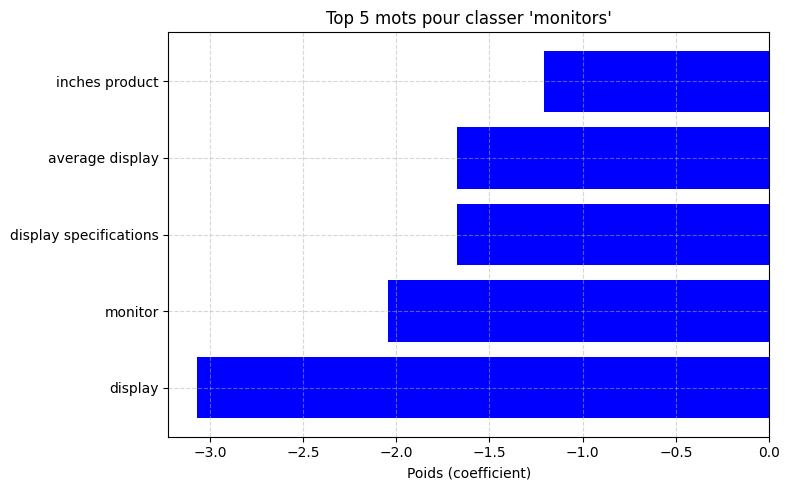

In [15]:
import matplotlib.pyplot as plt

def plot_top_words(class_label, coef, feature_names, top_n=5):
    if class_label == 'pc':
        top_indices = np.argsort(coef)[-top_n:]
        title = f"Top {top_n} mots pour classer 'pc'"
        color = 'green'
    else:
        top_indices = np.argsort(coef)[:top_n]
        title = f"Top {top_n} mots pour classer 'monitors'"
        color = 'blue'

    words = [feature_names[i] for i in top_indices]
    weights = [coef[i] for i in top_indices]

    plt.figure(figsize=(8, 5))
    plt.barh(words, weights, color=color)
    plt.xlabel("Poids (coefficient)")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Appel pour chaque classe
plot_top_words('pc', coefs, feature_names)
plot_top_words('monitors', coefs, feature_names)
